LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [1]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data(read_volume=True)
df_prices, df_volumes = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

The parameters:
- `vp`/`vm`: Variable cost coefficients,
- `fp`/`fm`: Fixed cost coefficients,
- `up`/`um`: Upper bound of long and short side of the portfolio,
- `lp`/`lm`: Lower bound of long and short side of the portfolio,
- `pcoef`: Penalty term coefficient. (We use a penalty term to force either `xp` or `xm` to zero.)

In [6]:
def EfficientFrontier(N, m, G, deltas, vp, vm, fp, fm, up, um, lp, lm, pcoef):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Real variables 
        # The variable x is the fraction of holdings in each security.    
        x = M.variable("x", N, Domain.unbounded())
        xp = M.variable("xp", N, Domain.greaterThan(0.0))
        xm = M.variable("xm", N, Domain.greaterThan(0.0))
        
        # Binary variables
        yp = M.variable("yp", N, Domain.binary())
        ym = M.variable("ym", N, Domain.binary())
        
        # Constraint assigning xp and xm to be the positive and negative part of x.
        M.constraint('pos-neg-part', Expr.sub(x, Expr.sub(xp, xm)), Domain.equalsTo(0.0))
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
        
        # Auxiliary variable for 130/30 leverage constraint 
        z = M.variable("z", N, Domain.unbounded())

        # Bound constraints
        M.constraint('ubound-p', Expr.sub(Expr.mul(up, yp), xp), Domain.greaterThan(0.0))
        M.constraint('ubound-m', Expr.sub(Expr.mul(um, ym), xm), Domain.greaterThan(0.0))
        M.constraint('lbound-p', Expr.sub(xp, Expr.mul(lp, yp)), Domain.greaterThan(0.0))
        M.constraint('lbound-m', Expr.sub(xm, Expr.mul(lm, ym)), Domain.greaterThan(0.0))
        
        # Exclusive buy-sell constraint
        M.constraint('exclusion', Expr.add(yp, ym), Domain.lessThan(1.0))
        
        # Budget constraint with transaction cost terms
        fixcost_terms = Expr.add([Expr.dot(fp, yp), Expr.dot(fm, ym)])
        varcost_terms = Expr.add([Expr.dot(vp, xp), Expr.dot(vm, xm)])
        budget_terms = Expr.add([Expr.sum(x), varcost_terms, fixcost_terms])
        M.constraint('budget', budget_terms, Domain.equalsTo(1.0))

        # 130/30 leverage constraint
        M.constraint('leverage-gt', Expr.sub(z, x), Domain.greaterThan(0.0))
        M.constraint('leverage-ls', Expr.add(z, x), Domain.greaterThan(0.0))
        M.constraint('leverage-sum', Expr.add([Expr.sum(z), varcost_terms, fixcost_terms]), Domain.equalsTo(1.6))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        penalty = Expr.mul(pcoef, Expr.sum(Expr.add(xp, xm)))
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.sub(Expr.dot(m, x), penalty), Expr.mul(delta, s)))
        
        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 1, Expr.mul(G.transpose(), x)), Domain.inRotatedQCone())
    
        columns = ["delta", "obj", "return", "risk", "x_sum", "tcost"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for idx, d in enumerate(deltas):
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = np.sqrt(2 * s.level()[0])            
            tcost = np.dot(vp, xp.level()) + np.dot(vm, xm.level()) + np.dot(fp, yp.level()) + np.dot(fm, ym.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, 
                             sum(x.level()), tcost] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [7]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, S = compute_inputs(df_prices)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [8]:
# Cholesky factor of S to use in conic risk constraint
G = np.linalg.cholesky(S)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-0.5},\dots,10^{2}$. We compute and plot the efficient frontier this way both with and without transaction cost. 

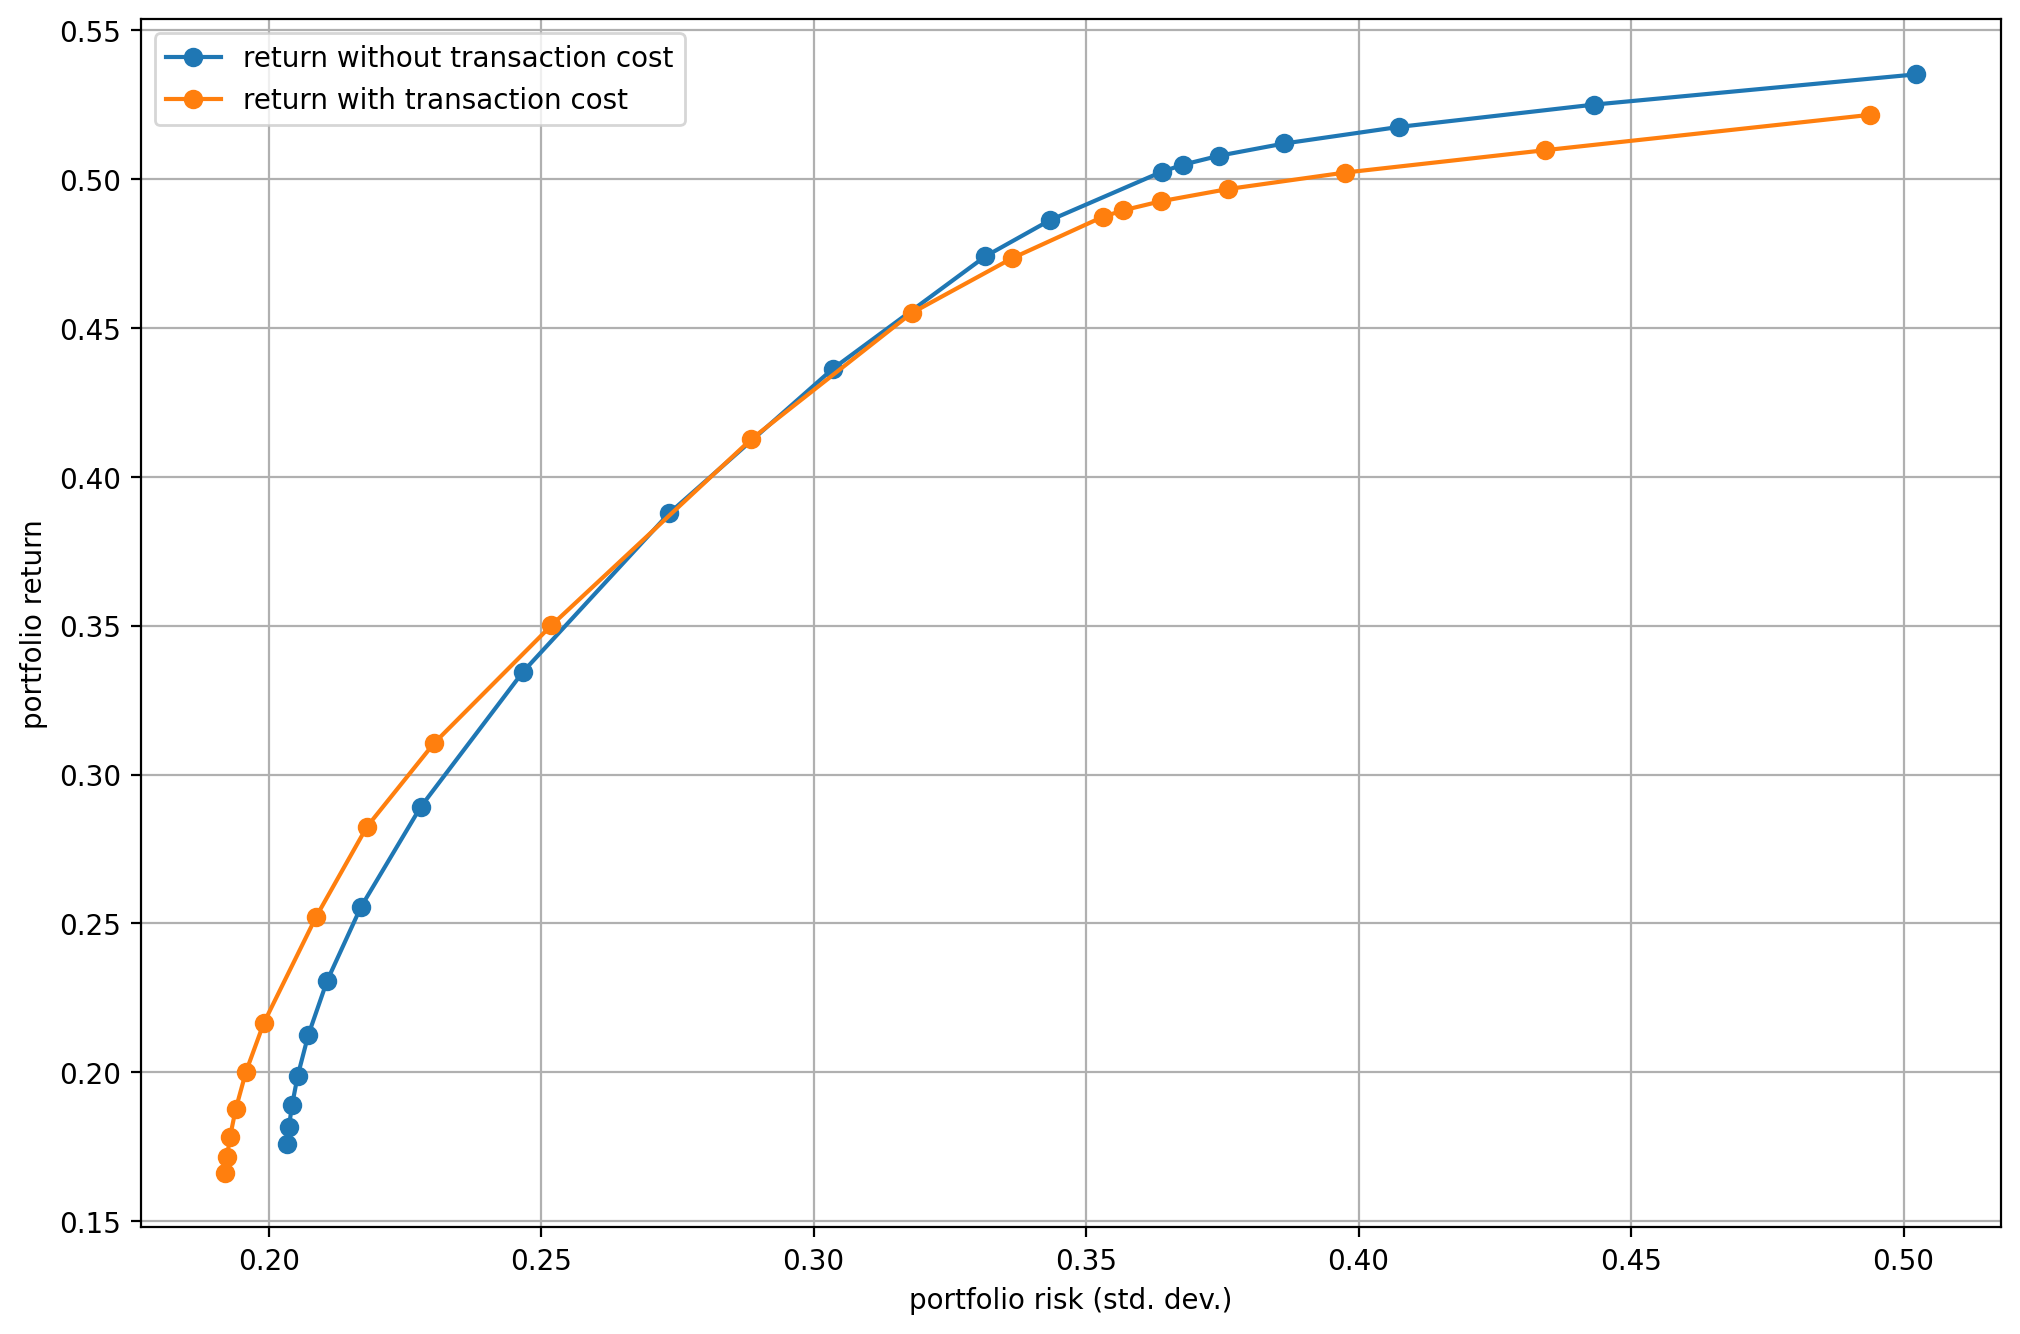

In [9]:
deltas = np.logspace(start=-0.5, stop=2, num=20)[::-1]
ax = plt.gca()
for a in [0, 1]:
    pcoef = a * 0.03
    fp = a * 0.005 * np.ones(N) # Depends on portfolio value
    fm = a * 0.01 * np.ones(N) # Depends on portfolio value
    vp = a * 0.01 * np.ones(N)
    vm = a * 0.02 * np.ones(N)
    up = 2.0
    um = 2.0
    lp = a * 0.05
    lm = a * 0.05

    df_result = EfficientFrontier(N, m, G, deltas, vp, vm, fp, fm, up, um, lp, lm, pcoef)
    df_result.plot(ax=ax, x="risk", y="return", style="-o", 
                   xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
ax.legend(["return without transaction cost", "return with transaction cost"]);